In [2]:
import requests
import base64
from urllib import urlencode
import time, timeit
import pandas as pd
import pickle
import HTMLParser
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cross_validation
import numpy as np
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from datetime import datetime, timedelta
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

# Copy your access token in the "twitter - Getting your access token" notebook then assign to the access_token variable below:

In [ ]:
access_token = "PASTE YOUR ACCESS TOKEN HERE"

In [74]:
class tweet_limit_tracker(object):
    
    """
    Class to monitor if the query will exceed the tweet download limit.
    """
    
    def __init__(self):
        if not os.path.isfile("df_log.pck"):
            temp_df = pd.DataFrame(columns=['time_extracted', 'num_tweets'])
            temp_df.to_pickle("df_log.pck")
        self.df_record = pd.read_pickle("df_log.pck")
        self.tweet_time_limit = timedelta(minutes=15)
        
        self.remove_lapsed_records()
    
    def reset(self):
        pass
    
    def remove_lapsed_records(self):
        self.df_record = pd.read_pickle("./misc/df_log.pck")
        if len(self.df_record) > 0:
            elapsed_time = self.df_record['time_extracted'].apply(lambda x: datetime.now() - x)
            self.df_record = self.df_record[elapsed_time < self.tweet_time_limit]
            self.df_record.reset_index(drop=True, inplace=True)
            self.df_record.to_pickle("./misc/df_log.pck")
        
    def log(self, _datetime, _num_tweets):
        temp_row = pd.DataFrame()
        temp_row['time_extracted'] = [_datetime]
        temp_row['num_tweets'] = [_num_tweets]
        
        self.df_record = pd.read_pickle("./misc/df_log.pck")
        self.df_record = self.df_record.append(temp_row)
        self.df_record.reset_index(drop=True, inplace=True)
        self.df_record.to_pickle("./misc/df_log.pck")
        
        self.remove_lapsed_records()
    
    def determine_if_exceed(self, _num_tweets=0):
        self.remove_lapsed_records()
        exceed = (_num_tweets + self.df_record['num_tweets'].sum()) > 450
        return exceed
    
    def current_record(self):
        self.remove_lapsed_records()
        print(self.df_record)
        
    def current_count(self):
        self.remove_lapsed_records()
        return self.df_record['num_tweets'].sum()

In [75]:
class tweets_sentiment_analyzer(object):
    """
    Class to automatically track sentiment of tweets on a given keyword or phrase query.
    """
    
    def __init__(self, query, omit_words = [":)", ":D", ":(", ":|", "RT"]):
        self.query = query
        self.query_base = 'https://api.twitter.com/1.1/search/tweets.json?'
        self.tracker = tweet_limit_tracker()
        self.omit_words = omit_words
        
        self.access_token = access_token
        self.headers = {'Authorization' : 'Bearer {}'.format(self.access_token),}
    
    def extract_tweets(self, query_str, num_tweets):
        """
        Function to extract tweets.

        Parameters:
        query_text -> the url encoded query text
        num_tweets -> number of tweets to extract

        Return value:
        A dataframe of the tweets.
        """
        
        will_exceed = self.tracker.determine_if_exceed(num_tweets)
        
        if will_exceed:
            print("Warning: Conintuing the extraction will exceed \
                   the limit set by the Twitter API. The program will space out\
                   the extraction so as to avoid getting blocked.")

        query_url = self.query_base + urlencode({'q':query_str, 'src':'typd'}) 

        #variable to track if we are about to exceed extracted tweet limit in a 15-min span
        #program should check this and call time.sleep(15*60)
        #should be reset after each call to time.sleep()
        exceeding_limit = self.tracker.current_count()

        remaining_tweets_to_extract = num_tweets
        tweets_extracted = 0


        batch_tweets = list()
        append_max_id_arg = ''

        while (remaining_tweets_to_extract > 0):

            if remaining_tweets_to_extract >= 100:
                current_batch_count = 100
            else:
                current_batch_count = remaining_tweets_to_extract

            exceeding_limit += current_batch_count

            if exceeding_limit > 450:
                #time delay function here...
                time.sleep(15*60)
                exceeding_limit = 0 #reset            

            query_text_temp = query_url + '&count=' + str(current_batch_count) + append_max_id_arg
            current_batch = requests.get(query_text_temp, headers=self.headers).json()['statuses']
            batch_tweets = batch_tweets + current_batch

            #inspect if the most recent query returned at least 1 tweet.
            #otherwise, terminate.
            if len(current_batch) > 0:
                min_id = batch_tweets[-1]['id']
            else:
                return batch_tweets

            append_max_id_arg = '&max_id=' + str(min_id-1)

            remaining_tweets_to_extract -= current_batch_count
            
            #log to tweet_limit_tracker
            tweets_extracted = len(current_batch)
            self.tracker.log(datetime.now(), tweets_extracted)
            
            exceeding_limit -= current_batch_count
            exceeding_limit += self.tracker.current_count()

        return batch_tweets
    
        
    def fetch_training_data(self, tweets_per_label=10):
        
        self.x_train_pos = self.extract_tweets(query_str = '"' + self.query + '"' + ' :)', num_tweets=tweets_per_label)
        self.x_train_neg = self.extract_tweets(query_str = '"' + self.query + '"' + ' :(', num_tweets=tweets_per_label)
        self.x_train_neut = self.extract_tweets(query_str = '"' + self.query + '"' + ' :|', num_tweets=tweets_per_label)
        
        #store how many tweets per label were extracted
        self.num_pos = len(self.x_train_pos)
        self.num_neg = len(self.x_train_neg)
        self.num_neut = len(self.x_train_neut)
        
        #Store only up to the fewest count per label(pos, neg, neut)
        #so as to balance the training data.
        self.training_data_per_label = min(self.num_pos, self.num_neg, self.num_neut)
        self.x_train_pos = self.x_train_pos[:self.training_data_per_label]
        self.x_train_neg = self.x_train_neg[:self.training_data_per_label]
        self.x_train_neut = self.x_train_neut[:self.training_data_per_label]
        
        self.x_train_pos_tweets = [ind['text'] for ind in self.x_train_pos]
        self.x_train_neg_tweets = [ind['text'] for ind in self.x_train_neg ]
        self.x_train_neut_tweets = [ind['text'] for ind in self.x_train_neut]
    
    def fetch_data_to_analyze(self, tweets_to_test=10):
        self.tweets_to_test = tweets_to_test
        self.x_test = self.extract_tweets(query_str = self.query, num_tweets=tweets_to_test)
        self.x_test_tweets = [ind['text'] for ind in self.x_test]
        
    def preprocess_text(self, tweets):
        #Text preprocessing
        
        #Tokenize the tweets
        tknzd_tweets = [self.tokenize_(tweet) for tweet in tweets]

        #Join back the tokenized, cleaned tweets
        cleaned_tweets = [' '.join(tweet) for tweet in tknzd_tweets]

        return cleaned_tweets
    
    def train(self):
        
        self.x_train_pos_cleaned = self.preprocess_text(self.x_train_pos_tweets)
        self.x_train_neg_cleaned = self.preprocess_text(self.x_train_neg_tweets)
        self.x_train_neut_cleaned = self.preprocess_text(self.x_train_neut_tweets)
        
        #create the features matrix plus the labels from the training data
        self.X_train_all = self.x_train_pos_cleaned + self.x_train_neg_cleaned \
                            + self.x_train_neut_cleaned
        self.y_train_all = [1]*self.training_data_per_label  + [-1]*self.training_data_per_label  \
                        + [0]*self.training_data_per_label 
            
        self.tfidfVectorizer = TfidfVectorizer()
        self.tfidf_train = self.tfidfVectorizer.fit_transform(self.X_train_all)
        
        folds = min(10, len(self.X_train_all))
        
        C_ = list(np.arange(0.2, 3.0, 0.2))
        kernel_ = ['linear', 'poly', 'rbf', 'sigmoid']
        degree_ = [1, 2, 3, 4, 5]
        params_dict = {'C': C_, 'kernel': kernel_, 'degree': degree_}

        self.clf_svc = svm.SVC()
        self.clf_svc_grid = GridSearchCV(estimator=self.clf_svc, param_grid=params_dict, cv=10)

        self.clf_svc_grid.fit(self.tfidf_train.toarray(), np.array(self.y_train_all))
        
    def show_sentiment(self):
        #self.fetch_data_to_analyze()
        self.x_test_cleaned = self.preprocess_text(self.x_test_tweets)
        self.tfidf_test = self.tfidfVectorizer.transform(self.x_test_cleaned) #Note the common pitfall of calling fittransfrom instead of just transform
        
        self.pred = self.clf_svc_grid.predict(self.tfidf_test.toarray())
        
        plt.plot(self.pred)
        
    def tokenize_(self, tweet):
        
        html_parser = HTMLParser.HTMLParser()
        tokenized_tweet = [html_parser.unescape(word).lower() for word in tweet.split() if (word not in self.omit_words and not(word.startswith("http")))]

        #remove non-alphanumeric characters
        pattern = re.compile('[\W_]+', re.UNICODE)
        tokenized_tweet = [pattern.sub('', word) for word in tokenized_tweet]
        return tokenized_tweet
    
    def show_test_tweets(self):
        
        for tweet in self.x_test_tweets:
            print('\n')
            print(tweet)
    
    def show_train_tweets(self,label):
        
        if label=='neutral':
            for tweet in self.x_train_neut_tweets:
                print('\n')
                print(tweet)
        elif label=='pos':
            for tweet in self.x_train_pos_tweets:
                print('\n')
                print(tweet)
        elif label=='neg':
            for tweet in self.x_train_neg_tweets:
                print('\n')
                print(tweet)
        else:
            print("Invalid label argument passed.")

# Below are examples of how to use the "tweets_sentiment_analyzer" class

In [5]:
analyzer = tweets_sentiment_analyzer(query="durant")

In [6]:
start = timeit.default_timer()
analyzer.fetch_training_data(tweets_per_label=100)
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 10.7800400257


In [7]:
start = timeit.default_timer() 
analyzer.train()
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 524.982668877


In [8]:
start = timeit.default_timer() 
analyzer.fetch_data_to_analyze(tweets_to_test=150)
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 906.746759176


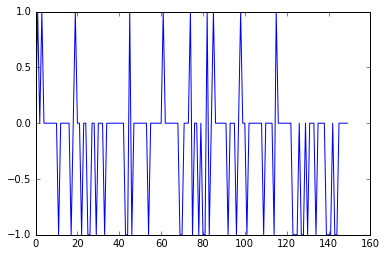

In [9]:
analyzer.show_sentiment()

In [10]:
analyzer.pred.mean()

-0.16666666666666666

In [11]:
analyzer.pred

array([ 0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
       -1,  0,  1,  0,  0, -1,  0,  0, -1, -1,  0,  0, -1,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1, -1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0, -1, -1,  0,  0,  0,  1, -1,  0,  0, -1,  0, -1, -1,  1, -1,  0,
        1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  1,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  1,  0,  0,  0,
        0,  0,  0,  0, -1, -1, -1,  0, -1, -1,  0, -1,  0,  0,  0, -1,  0,
        0,  0,  0, -1, -1, -1,  0, -1, -1,  0,  0,  0,  0,  0])

In [13]:
analyzer.show_test_tweets()



RT @SportsNation: #TBT to the @warriors free agency meeting with Kevin Durant https://t.co/ITmflqxDDI


RT @AbdouPriince: Frere ton peuple souffert durant des siecles des hommes ce sont fait torturer des femmes violer et tu vient lacher des "j…


A Look Inside Kevin Durant &amp; Nike's "852 x KD" Exhibition in Hong Kong https://t.co/sfciYT8IZZ via Hypebeast


Whose #FreeAgency move was more surprising -- Wade to CHI or Durant to GSW?

BLOGTABLE: https://t.co/eGOADoDLL2 https://t.co/7WVhiTpepw


Considering Russell Westbrook's future after Kevin Durant broke his Thunder buddy's heart https://t.co/pKoCIpv71W via @YahooBDL


RT @SneakerNews: Kevin Durant and LeBron addressing haters (KD after signing with GS, LeBron after losing '11 Finals) https://t.co/ZOcmj2a5…


To the baes like Durant


RT @SportsCenter: Kevin Durant better get ready for Iman Shumpert next season. 
https://t.co/sg6uE4ml2N


RT @GirlsGoneWild: *Durant to GSW and Wade to the Bulls*
"JR... JR put the bottle down nigga 

In [14]:
for tweet in analyzer.x_train_neg_tweets:
    print('\n')
    print(tweet)



RT @PoussiG: Le coup du réchauffement, ça va bien. Je n'ai jamais eu aussi froid que durant ce mois de juillet... :( https://t.co/R3PVcKRT3N


Le coup du réchauffement, ça va bien. Je n'ai jamais eu aussi froid que durant ce mois de juillet... :( https://t.co/R3PVcKRT3N


@rockabilly4428 @MrSirban Il a été courageux de parvenir à survivre 7 mois durant avec sa pleurésie :(


TAME kittens at the Durant City Pound. The first kitten fell out from under a moving car :( It is ok, but skinned... https://t.co/zwHHuUABH3


Kevin Durant says bond with Russell Westbrook 'won't ever be the same' - via @ESPN App
:( https://t.co/HLezptcV3f


Mais je me tâte niveau sous car je comptais garder ce taf durant mes études (au moins de septembre à Mars) que faire ? :( (3/3)


Pasamos de las fotos de K.Durant con el 35 #Celtics de Reggie Lewis
:-(
A Westbrook con el 0, de A.Bradley
¡Que lo tenemos en plantilla!
:-(


Durant and Westbrook’s relationship won’t ever be the same :( https://t.co/L0R2lmbXIz ht

In [15]:
for tweet in analyzer.x_train_pos_tweets:
    print('\n')
    print(tweet)



RT @Joe_Sugg: New video on the way from https://t.co/z2O7U3u44S todays video is a THROWBACK THURSDAY video and I'm very excited :D


Hum... ça sent les vacances :) 

Et j'ai préparé une série d'articles spéciaux que je te ferai parvenir durant... https://t.co/W4hGmler9M


@4GenSFFanFam @eteachout Yes! Power Duo! The Durant and Curry of content/comments. :)


@kaankural @ardabocek  bende durant'la konuştun sandim :))


@HolaHova @jscari24 @ESPNNBA yeah good luck getting to the playoffs. He sure proved he can get there without durant :)


RT @JarodJosephFR: Je vais publier les photos de Jarod durant les panels à la famille réunion, vous pouvez aussi nous envoyer vos photoshoo…


@gozdecorlan @kadirovic8 ama en çok cavs serisinde durant vs kevin loveı merak ediyorum :D


Je vais publier les photos de Jarod durant les panels à la famille réunion, vous pouvez aussi nous envoyer vos photoshoot en dm :)


ON AIME | La musique fait vivre les rues de Québec durant l'été, il y en a vraiment po

In [16]:
for tweet in analyzer.x_train_neut_tweets:
    print('\n')
    print(tweet)



RT @SportsNation: #TBT to the @warriors free agency meeting with Kevin Durant https://t.co/ITmflqxDDI


RT @SportsNation: #TBT to the @warriors free agency meeting with Kevin Durant https://t.co/ITmflqxDDI


RT @LorenzoCromwell: When Kevin Durant Left OKC 😩 smfh w/ @Klarity https://t.co/tqC7AuIBlq


RT @kaankural: Durant'in Golden State'e gidişini @ardabocek ile konuştuk https://t.co/qWkjxemZXU


RT @FullyChelsea: Conte: "Je ne suis pas doué pour me trouver des surnoms. J'espère que durant la saison vous en trouverez pour moi."


@Caith_Sith Lo que te tuerce la pokeball no es la baya, es la mala programación del lanzamiento, se cree que la lanzas con efecto (agitando)


RT @SportsNation: #TBT to the @warriors free agency meeting with Kevin Durant https://t.co/ITmflqxDDI


Clams Casino Gets Verses From A$AP Rocky and Lil B on ‘Be Somebody’: Kevin Durant's departure to Golden State... https://t.co/oizlZHduK3


RT @ESPNNBA: Kevin Durant admits his bond with Russell Westbrook "won't ever

In [17]:
analyzer = tweets_sentiment_analyzer(query="tim duncan")

In [18]:
start = timeit.default_timer()
analyzer.fetch_training_data(tweets_per_label=100)
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 23.9534790516


In [19]:
start = timeit.default_timer() 
analyzer.train()
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 337.560465097


In [20]:
start = timeit.default_timer() 
analyzer.fetch_data_to_analyze(tweets_to_test=150)
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 913.835080147


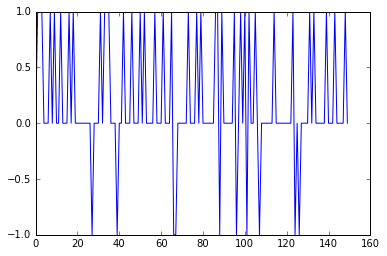

In [21]:
analyzer.show_sentiment()

In [22]:
analyzer.pred.mean()

0.17999999999999999

In [23]:
analyzer.pred

array([ 0,  1,  1,  1,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  0,  1,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  1,
        1,  1,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,
        0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1, -1, -1,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,
        0,  1,  1, -1,  1,  0,  0,  0,  0,  0,  1, -1,  0,  1,  0,  1, -1,
        1,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  1, -1,  0, -1,  0,  0,  0,  0,  1,  0,  1,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0])

In [24]:
analyzer.show_test_tweets()



RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


RT @NBAInside_Stuff: Tim Duncan and Kawhi Leonard's conversations be like😂😂 https://t.co/cqoBib8adf


RT @LV_Sports: Good, better, best. Never let it rest. Until your good is better and your better is best. -Tim Duncan


RT @NBABeLike: Thank You Tim Duncan 👏🏻
https://t.co/nO4ARwP2dV


RT @GVazquezNY: Proporción de minutos y posición en Tim Duncan desde el año 2000. 
En azul, jugó como cuatro. 
En rojo, como cinco. https:/…


RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


Muy buena!! Una humildad en su juego un grande tim duncan!! 🏀🏀🏀🏀 https://t.co/0LRRvyvOmC


RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


RT @TimDuncanDaily: Sam Smith and Jim Boylen on Tim Duncan https://t.co/67FolfncHK


RT @Insane_Athletes: Tim Duncan has never

In [25]:
for tweet in analyzer.x_train_neg_tweets:
    print('\n')
    print(tweet)



George Clooney &amp; Derek Jeter are married, Tim Duncan &amp; Kobe retired. The 1990s are officially dead. :-(


Also Tim Duncan fans :( https://t.co/Z0z6TeFCO4


Se nos acaban los héroes :( se nos fue payton manning, Kobe y el gran Tim Duncan :(


Foo, Tim Duncan se va :(


until now can't believe that i won't see tim duncan playing inside the basketball court again :( #fansince1998 #spurs4ever


RT @CTeter6: This year we've had to say goodbye to Peyton Manning, Kobe Bryant, Tim Duncan, and next up Big Papi. What a rough year :( #Res…


Tim Duncan :( https://t.co/BIpFpgR3FS


RT @SeahorsePuncher: I know I tweeted about him yesterday, but Tim Duncan was the definition of a furious competitor and perfect teammate.…


RT @thefumusic: who are you gonna miss more after this year? tim duncan or kobe bryant? :(


I don't wanna talk about Tim Duncan retirement right now.
Sigh :(


I don't want Tim Duncan to retire :(


It's sad to see Tim Duncan leave the league now :(


I wake up everyday

In [26]:
for tweet in analyzer.x_train_pos_tweets:
    print('\n')
    print(tweet)



Tribute For The Greatest Power Forward In The NBA. Thanks #TD!  Get Yours Here &gt;&gt;&gt;https://t.co/4ZnIiWtyKe  :)... https://t.co/peFomQkyoZ


En el especial de TrueHoop sobre Tim Duncan, @ZachLowe_NBA se acuerda de nuestro Ricky Peral :D . Fan. https://t.co/oKqIydgUjC


@VanessaLMacias missing Tim Duncan already
.. :)


@marimolina385 LOL. Does this make me Tim Duncan of the Paragraph Factory :)


@beafabregas Take a look! Timmy's letter to the fans. :) https://t.co/ykENWk8Z9V


Everyone thinks of Tim Duncan and the bank shot. In my day it was Scottie Pippen who was the bank president :)


Tim Duncan pens farewell letter to Spurs fans. Just classy.  #ThankYouTD :) :) :)  https://t.co/umYxUE91NO via @mySA


RT @DanRoseMMA: @PreeVader Sadly, my mom will learn something new about me too....lol.  Can't believe we didn't talk any Tim Duncan :)


@PreeVader Sadly, my mom will learn something new about me too....lol.  Can't believe we didn't talk any Tim Duncan :)


I am going to miss

In [27]:
for tweet in analyzer.x_train_neut_tweets:
    print('\n')
    print(tweet)



RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


RT @W0RLDSTARHlPHOP: Tim Duncan has been in every 2K basketball game https://t.co/QOv3VSB0Xj


RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


RT @WSHHFANS: Tim Duncan has been in every 2K basketball game https://t.co/gHpqxcGna5


RT @Insane_Athletes: Tim Duncan has never seen a hook shot he couldn't make #ThankYouTimmy https://t.co/4xaxNfg5eO


tim duncan nba #tim #duncan #nba #timduncannba.

Time Post: Fri Jul 15 03:30:30 ICT 2016
Link: … https://t.co/oxDuaIfEOy


RT @LegionHoops: Tim Duncan has been in every 2K basketball game. Dreamcast - NBA2K16 (via @Steve_OS) https://t.co/QyQIbMEhtS


Dawwwwg Kobe and Tim Duncan retired wtf


The San Antonio Spurs have signed Pau Gasol, beefing 

In [46]:
analyzer = tweets_sentiment_analyzer(query="france")

In [47]:
start = timeit.default_timer()
analyzer.fetch_training_data(tweets_per_label=50)
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 906.208350182


In [48]:
start = timeit.default_timer() 
analyzer.train()
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 73.2240669727


In [49]:
start = timeit.default_timer() 
analyzer.fetch_data_to_analyze(tweets_to_test=50)
stop = timeit.default_timer()
print("Runtime: {0}".format(stop-start))

Runtime: 1.71969914436


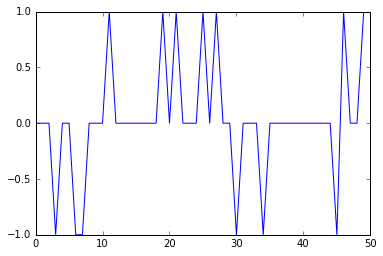

In [50]:
analyzer.show_sentiment()

In [51]:
analyzer.pred.mean()

0.02

In [52]:
analyzer.pred

array([ 0,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  1])

In [53]:
analyzer.show_test_tweets()



RT @NBCNews: LATEST: Vatican condemns 'senseless violence' after #Nice truck attack https://t.co/z8gYF8XpZ7 #NiceFrance https://t.co/YGZF63…


RT @camilacabello97: I can't believe what happened in France today. the worst part is these hateful tragedies are only seeming more common…


#News Bastille Day terror attack leaves dozens dead in Nice https://t.co/RlVE72uuTJ


RT @Charlie_Carver: Nice 💔 Sending love to you and all of France this Bastille Day #prayfornice


RT @afpfr: #Nice François Hollande décrète trois jours de deuil national en France, de samedi à lundi #AFP


RT @CNN: So far, no group has claimed responsibility for #NiceAttack https://t.co/OVs3wugYbb https://t.co/OjvSoNQfNc


RT @Dezeen: Philippe Starck and Luc Arsène-Henry build steel wine cellar in Bordeaux: https://t.co/7iEFWpQks6 https://t.co/BdxQeo2uF7


#News Bastille Day attack: What we know so far https://t.co/pkqBr4vLbI


RT @paul__johnson: World reacts to Foreign Sec
US - laughter
Germany - he's hated
France - l

In [54]:
for tweet in analyzer.x_train_neg_tweets:
    print('\n')
    print(tweet)



RT @HilaryDuff: Devastating how humans can treat other humans.i am horrified by what is happening in France. And all over the world :( it's…


Morning world. Sadness today, as the news from France keeps coming in, telling of more and more fatalities. :( #NiceAttack #RIPNice


Thinking of the people of France :(


I Love France and my heart is broken now. :( #PrayForNice #PrayForFrance


My thoughts are with the people of Nice and all of France at this terrible time.  No excuse for this display of violence :(


RT @Chixytv: So sad what happened in Nice France :( wtf is wrong with people 😭


Our thoughts are with those affected by the attack in #NiceFrance Yet another horrible attack on France :(


France to start their National Mourning day on Sat just after their National Day...What a pity :( because of #NiceAttack


RT @KeNNyBoySlay: I don't let things bother me, but reading about France is heart breaking. It was a national holiday and innocent people D…


RT @griziftzayn: Pendant u

In [55]:
for tweet in analyzer.x_train_pos_tweets:
    print('\n')
    print(tweet)



RT @ducheisca: Henry de Lesquen il a raison sur un truc l'islam et la France sont incompatibles :)


@britneycharts #01 in France now :)


@superfine_de No worries :-) it's sad for France... Again...


RT @black_mamba_06: #QuickHELLO Darlings&lt;3 #14thJULLY in France&lt;3 Send U #Love #Smiles &amp; #Happiness&lt;3 #ALL!:) XO @PeterTWD @misslinn2 &amp; htt…


@SamClamote Thank you for following, Samuel ... heartfelt thoughts for #France #Nice today, we are one with you :)


RT @black_mamba_06: #QuickHELLO Darlings&lt;3 #14thJULLY in France&lt;3 Send U #Love #Smiles &amp; #Happiness&lt;3 #ALL!:) XO @PeterTWD @misslinn2 &amp; htt…


Pokémon Go lancé en Italie, Espagne et Portugal aujourd'hui. Toujours pas la france :D. On doit être un trop gros public.


RT @YEPitsCAG: thank you france for inventing parkour :) #CAGRhay #parkour


RT @InGodneyWeTrust: #MakeMe is #1 in France! :)


@PhillyD The attack in France was horrific I can understand it because it has happened to us but all I mean

In [56]:
for tweet in analyzer.x_train_neut_tweets:
    print('\n')
    print(tweet)



RT @Styllicious: tu meurs dans un concert, à un match, sur une terrase de café, à la fête nationale... voir une France heureuse ne leurs pl…


RT @iamdanielskye: Sending love to everyone in France. Hope you all are OK. Stay strong ❤️


RT @NasNacera: France 2 vient d'interviewer 2 familles à cotés des cadavres de leurs proches #Nice06 https://t.co/7v3sGrTeiB


@Paris @Anne_Hidalgo bouger vous le cuq putin , moi j'etais a l'armee avant bientot ils aura des mercenaires en france pour faire votre taf


RT @sandraregol: #Philippot sur @franceinfo : Sa haine qui souffle pour attiser la douleur et les peurs est une insulte aux victimes et à l…


RT @BBCBreaking: #NiceAttack latest:

- 84 killed, 50 injured
- Children among victims
- France extends state of emergency

https://t.co/UV…


RT @adamlambert: Nice, France 💔 https://t.co/lElwFM4ew5


Vous aussi vous avez fait la fête hier ? TidyBear est là @Tidybear_France https://t.co/ALdGkS8FgP #fete #jeunes #soiree #14juillet


#PrayForNice Dev